# Figure 2: Illustration of graphical method for finding best adaptation strategy in uncorrelated environments

Goal: illustration of the steps of the graphical method

In [1]:
import numpy as np
import scipy.spatial

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['transitions.mplstyle'])
import matplotlib
colors = matplotlib.rcParams['axes.prop_cycle'].by_key()['color']
from matplotlib import patches

import sys
sys.path.append('lib/')
import evolimmune, plotting

In [2]:
def paretofrontier(points):
    "Naive Pareto frontier calculation of a set of points where along every axis larger is better"
    paretopoints = []
    for point in points:
        if not np.any(np.all(points - point > 0, axis=1)):
            paretopoints.append(point)
    paretopoints.sort(key=lambda row: row[0])
    return np.asarray(paretopoints)

In [3]:
fs = []
prng = np.random.RandomState(1234)
while len(fs) < 20:
    f = prng.rand(2)
    a = 1.7
    if f[1] < (1.0-f[0]**(1.0/a))**a and np.amin(f) > 0.04:
        if not fs or (np.amin(np.sum((f - np.asarray(fs))**2, axis=1)**.5) > 0.05):
            fs.append(f)
fs = np.asarray(fs)

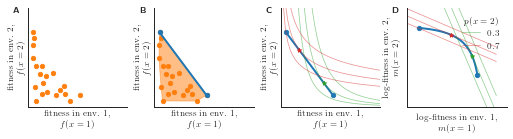

In [4]:
pienvs = [0.3, 0.7]
fig, axes = plt.subplots(figsize=(7, 2), ncols=4, subplot_kw=dict(aspect='equal'))

# plot phenotype fitnesses
for ax in [axes[0], axes[1]]:
    ax.scatter(fs[:, 0], fs[:, 1], color=colors[1])

# calculate and plot convex hull
hull = scipy.spatial.ConvexHull(fs)
p = patches.Polygon(fs[hull.vertices], alpha=0.5, color=colors[1])
axes[1].add_patch(p)

# calc pareto
pareto = [f for f in fs[hull.vertices] if f in paretofrontier(fs)]
pareto.sort(key=lambda row: row[0])
pareto = np.asarray(pareto)

# plot pareto boundaries
for ax in [axes[1], axes[2]]:
    ax.plot(pareto[:, 0], pareto[:, 1], '-', c=colors[0], lw=2.0)
for i in range(len(pareto)-1):
    N = 100
    x, y = pareto[i:i+2, 0], pareto[i:i+2, 1]
    axes[3].plot(np.linspace(x[0], x[1], N), np.linspace(y[0], y[1], N), '-', c=colors[0], lw=2.0)  
for ax in [axes[1], axes[2], axes[3]]:
    ax.plot(pareto[:, 0], pareto[:, 1], 'o', c=colors[0], markeredgecolor=colors[0])

# calc optimal fitnesses for different pienvs
copts = []
opts = []
for pienv in pienvs:
    for i in range(len(pareto)-1):
        pih = evolimmune.pihat(pienv, pareto[i], pareto[i+1])
        if 0.0 < pih < 1.0:
            opt = pareto[i]*pih + pareto[i+1]*(1.0-pih)
            opts.append(opt)
    copts.append(pienv*np.log(opt[1]) + (1.0-pienv)*np.log(opt[0]))

    
# plot isolines
f0 = np.linspace(0.001, 0.999)
handles = [None, None]
for i, copt in enumerate(copts):
    pienv = pienvs[i]
    alpha = (1.0-pienv)/pienv
    for dc in [-0.2, 0.0, 0.2]:
        c = copt + dc
        for ax in [axes[2], axes[3]]:
            l, = ax.plot(f0, np.exp(c/pienv)/f0**alpha, '-', c=colors[i+2], lw=.75, alpha=.5)
            handles[i] = l
axes[3].legend(handles, pienvs, title='$p(x=2)$')

# plot opt
for i, opt in enumerate(opts):
    for ax in [axes[2], axes[3]]:
        ax.plot(opt[0], opt[1], '*', c=colors[i+2], markeredgecolor=colors[i+2])

# axes limits, labels, etc.
for ax in [axes[0], axes[1], axes[2]]:
    ax.set_xlim(0.0, 0.9)
    ax.set_ylim(0.0, 0.9)
    ax.set_xlabel('fitness in env. 1,\n$f(x=1)$')
    ax.set_ylabel('fitness in env. 2,\n$f(x=2)$')
ax = axes[3]
ax.set_xlim(0.03, 1.5)
ax.set_ylim(0.03, 1.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('log-fitness in env. 1,\n$m(x=1)$')
ax.set_ylabel('log-fitness in env. 2,\n$m(x=2)$')
for ax in axes:
    plotting.despine(ax)
    ax.set_xticks([])
    ax.set_yticks([])
plotting.label_axes(axes, xy=(-0.15, 0.95))
fig.tight_layout(pad=0.25)
fig.savefig('svgs/graphicalmethod.svg')

**Illustration of the steps of a graphical method for finding the best adaptation strategy in uncorrelated environments.** (A) Fitness values of phenotypes across environments (orange dots). (B) Fitness values achievable by switching strategies (orange area) are those inside the convex hull of the fitness values of the different phenotypes. A necessary condition for optimality is to lie on the Pareto frontier (blue line). (C, D) The optimal strategy has the fitnesses (red/green star) at which the isolines of the long-term growth rate for given environmental frequencies (red lines for $p(2)=0.7$, green lines for $p(2)=0.3$) are tangential to the Pareto frontier. (C) In fitness space the isolines are curved. (D) To determine the optimal strategy it is more convenient to work in log-fitness space, where the isolines are straight lines.